In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler
import time
from PIL import Image
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import os
from collections import defaultdict
import copy
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

In [4]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
class CNNModel(nn.Module):
    def __init__(self, n_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [6]:
def get_model(model_type='custom_cnn', class_names=[]):
    n_classes = len(class_names)
    if model_type == 'custom_cnn':
        return CNNModel(n_classes)

In [29]:


def load_datasets(dataset_dirs):
    datasets_list = []
    class_names = []
    plant_image_counts = defaultdict(lambda: {'total': 0, 'train': 0, 'val': 0, 'test': 0})

    for dataset_dir in dataset_dirs:
        plant_name = os.path.basename(dataset_dir)
        dataset = datasets.ImageFolder(root=dataset_dir)

        dataset.classes = [f"{plant_name}_{cls}" for cls in dataset.classes]
        class_names.extend(dataset.classes)

        plant_image_counts[plant_name]['total'] = len(dataset)
        datasets_list.append(dataset)

    combined_dataset = ConcatDataset(datasets_list)


    dataset_offsets = []
    offset = 0
    for ds in datasets_list:
        dataset_offsets.append((offset, offset + len(ds), ds))
        offset += len(ds)

    class_to_indices = defaultdict(list)
    for idx in range(len(combined_dataset)):
        for start, end, ds in dataset_offsets:
            if start <= idx < end:
                image, label = ds[idx - start]
                class_name = ds.classes[label]
                class_to_indices[class_name].append(idx)
                break

    train_indices, val_indices, test_indices = [], [], []

    for indices in class_to_indices.values():
        random.shuffle(indices)
        n = len(indices)
        train_cutoff = int(0.7 * n)
        val_cutoff = int(0.85 * n)

        train_indices.extend(indices[:train_cutoff])
        val_indices.extend(indices[train_cutoff:val_cutoff])
        test_indices.extend(indices[val_cutoff:])

    train_dataset = TransformDataset(torch.utils.data.Subset(combined_dataset, train_indices), transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(35),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

    val_dataset = TransformDataset(torch.utils.data.Subset(combined_dataset, val_indices), transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

    test_dataset = TransformDataset(torch.utils.data.Subset(combined_dataset, test_indices), transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))


    for subset, split in zip([train_dataset, val_dataset, test_dataset], ['train', 'val', 'test']):
        for index_in_subset, (image, label) in enumerate(subset):
            idx = subset.dataset.indices[index_in_subset]  

            for start, end, ds in dataset_offsets:
                if start <= idx < end:
                    class_name = ds.classes[label]
                    plant_name = class_name.split('_')[0]
                    plant_image_counts[plant_name][split] += 1
                    break

    return DataLoader(train_dataset, batch_size=32, shuffle=True), \
           DataLoader(val_dataset, batch_size=32, shuffle=True), \
           DataLoader(test_dataset, batch_size=32, shuffle=True), \
           list(set(class_names)), \
           dict(plant_image_counts)

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0


        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = (correct / total) * 100

        val_loss = 0.0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = (val_correct / val_total) * 100


        scheduler.step(val_loss)


        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{epochs}], Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [42]:
def evaluate_model(model, test_loader, classes):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels)) * 100


    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

In [32]:

dataset_dirs = ['/home/kkt/research/cropsight/Cotton', '/home/kkt/research/cropsight/Potato', '/home/kkt/research/cropsight/Wheat']
model_type = 'custom_cnn' 

In [33]:
train_loader, val_loader, test_loader, classes, plant_image_counts = load_datasets(dataset_dirs)

In [34]:
print(f"Number of classes: {len(classes)}")
print("Classes:")
for cls in classes:
    print(f"- {cls}")


Number of classes: 10
Classes:
- Cotton_bacterial_blight
- Cotton_curl_virus
- Wheat_Yellow_Rust
- Cotton_fussarium_wilt
- Potato_Late_Blight
- Cotton_healthy
- Wheat_Healthy
- Potato_Healthy
- Potato_Early_Blight
- Wheat_Brown_Rust


In [35]:
for plant, counts in plant_image_counts.items():
    print(f"{plant}: Total={counts['total']}, Train={counts['train']}, Validation={counts['val']}, Test={counts['test']}")

Cotton: Total=1710, Train=1195, Validation=257, Test=258
Potato: Total=2152, Train=1506, Validation=323, Test=323
Wheat: Total=2942, Train=2058, Validation=441, Test=443


In [36]:
model = get_model(model_type=model_type, class_names=classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [37]:
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
)

Epoch [1/30], Time: 55.43s, Train Loss: 0.9322, Train Acc: 71.0653, Val Loss: 0.5784, Val Acc: 78.3546
Epoch [2/30], Time: 55.49s, Train Loss: 0.5685, Train Acc: 80.0588, Val Loss: 0.4447, Val Acc: 84.6229
Epoch [3/30], Time: 55.26s, Train Loss: 0.5063, Train Acc: 81.1515, Val Loss: 0.3462, Val Acc: 87.8550
Epoch [4/30], Time: 55.34s, Train Loss: 0.4444, Train Acc: 84.0723, Val Loss: 0.2830, Val Acc: 89.4221
Epoch [5/30], Time: 55.41s, Train Loss: 0.3774, Train Acc: 86.6569, Val Loss: 0.2457, Val Acc: 90.6954
Epoch [6/30], Time: 55.36s, Train Loss: 0.3598, Train Acc: 87.4553, Val Loss: 0.2592, Val Acc: 90.3036
Epoch [7/30], Time: 55.37s, Train Loss: 0.2951, Train Acc: 89.5566, Val Loss: 0.1806, Val Acc: 94.0255
Epoch [8/30], Time: 55.39s, Train Loss: 0.2835, Train Acc: 89.7457, Val Loss: 0.2319, Val Acc: 91.5769
Epoch [9/30], Time: 55.75s, Train Loss: 0.2656, Train Acc: 90.5652, Val Loss: 0.2045, Val Acc: 92.8501
Epoch [10/30], Time: 55.40s, Train Loss: 0.2611, Train Acc: 90.2290, Val 

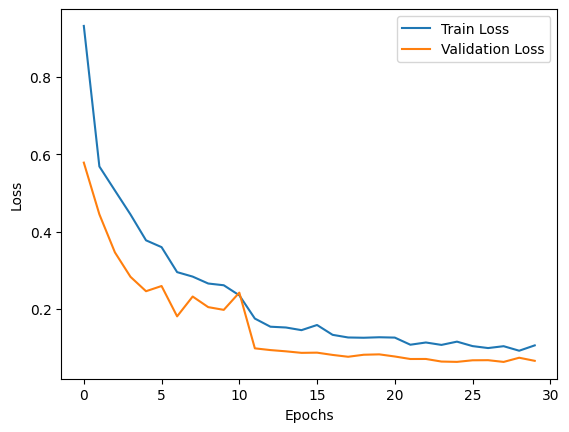

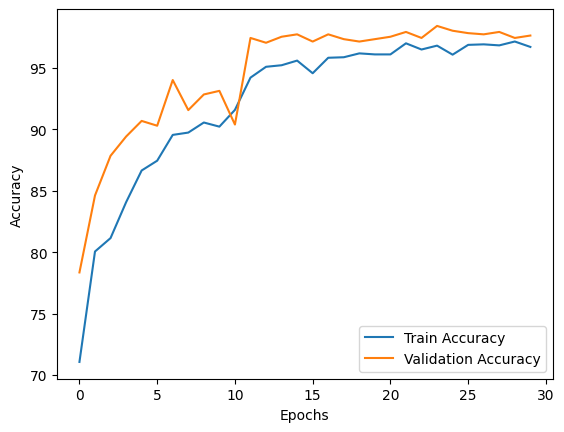

In [38]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
evaluate_model(model, test_loader, classes)

Test Accuracy: 97.85%
Precision: 0.98
Recall: 0.98


In [40]:
torch.save(model, 'cropsight_cnn_model_full.pth')
torch.save(model.state_dict(), 'cropsight_cnn_model_state_dict.pth')